# Deep Learning Text Classification Model

In [24]:
# %conda install tensorflow
# %conda install conda-forge::tensorflow-datasets
# %conda install conda-forge::tf-keras=2.17

In [25]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import datasets
import transformers
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# from tensorflow.keras import Input
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense, Bidirectional
# from tensorflow.keras.regularizers import L1, L2, L1L2
# from tensorflow.keras.optimizers import Adam, RMSprop

from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification

## Import Data

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
print(f"Train: {train.shape}\nTest: {test.shape}")

Train: (7613, 5)
Test: (3263, 4)


In [27]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [28]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [30]:
train['target'] = train['target'].astype('category')

* The compulsory columns, `text` and `target`, have no missing values.

## Exploratory Data Analysis

### `keyword`

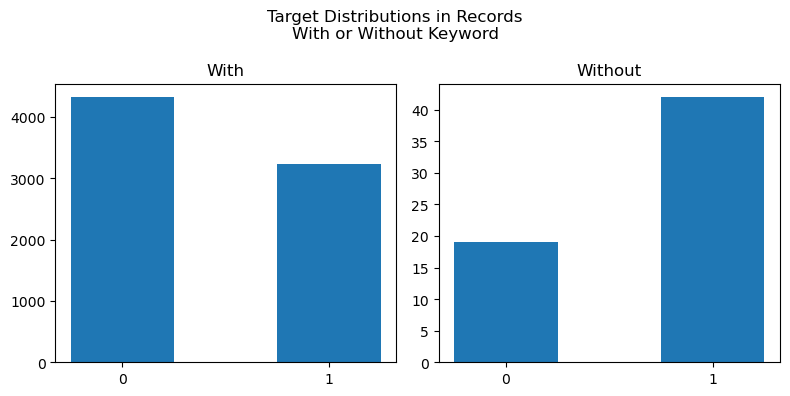

In [42]:
keyword_nomiss = train.loc[train['keyword'].notna(), ['keyword','target']]
keyword_miss = train.loc[train['keyword'].isna(), ['keyword','target']]

kw_nomiss_targets = keyword_nomiss['target'].value_counts()
kw_miss_targets = keyword_miss['target'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].bar(kw_nomiss_targets.index, kw_nomiss_targets, width=.5)
axes[0].set_xticks([0,1])
axes[0].set_title('With')
axes[1].bar(kw_miss_targets.index, kw_miss_targets, width=.5)
axes[1].set_xticks([0,1])
axes[1].set_title('Without')
fig.suptitle('Target Distributions in Records\nWith or Without Keyword')
fig.tight_layout()
plt.show()

* There is an apparent difference in `Target` distributions between records *`with`* and *`without`* `keyword`.
* Therefore, a new independent variable `with_keyword` should be considered.

### `location`

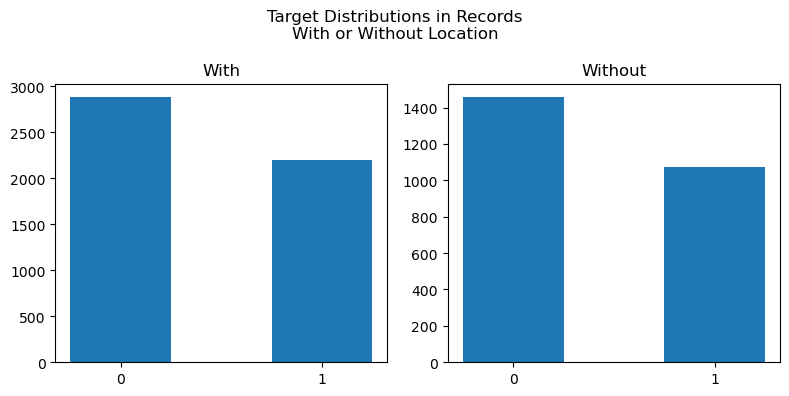

In [46]:
location_nomiss = train.loc[train['location'].notna(), ['location','target']]
location_miss = train.loc[train['location'].isna(), ['location','target']]

loc_nomiss_targets = location_nomiss['target'].value_counts()
loc_miss_targets = location_miss['target'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].bar(loc_nomiss_targets.index, loc_nomiss_targets, width=.5)
axes[0].set_xticks([0,1])
axes[0].set_title('With')
axes[1].bar(loc_miss_targets.index, loc_miss_targets, width=.5)
axes[1].set_xticks([0,1])
axes[1].set_title('Without')
fig.suptitle('Target Distributions in Records\nWith or Without Location')
fig.tight_layout()
plt.show()

* On the contrary, the `Target` distributions in the records *`with`* or *`without`* `location` show almost the same pattern.

## Create and Remove Columns

In [68]:
train['with_keyword'] = train['keyword'].notna().astype(int)
test['with_keyword'] = test['keyword'].notna().astype(int)
train['with_keyword'].value_counts()

with_keyword
1    7552
0      61
Name: count, dtype: int64

In [69]:
train.drop(columns='id', inplace=True)
test.drop(columns='id', inplace=True)
train.head()

,keyword,location,text,target,with_keyword
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0


## Text Preprocessing

In [71]:
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /Users/moswai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/moswai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/moswai/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/moswai/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Lowercase

In [72]:
train_lower = train['text'].str.lower()
test_lower = test['text'].str.lower()

### Punctuation

In [76]:
def punctuation(inputs):
    return re.sub(r'[^a-zA-Z]', ' ', inputs)
train_lower_punc = train_lower.apply(punctuation)
test_lower_punc = test_lower.apply(punctuation)

### Tokenisation

In [ ]:
def tokenization(inputs):
    return word_tokenize(inputs)
train_tokens = train_lower_punc.apply(tokenization)
test_tokens = test_lower_punc.apply(tokenization)

0       [our, deeds, are, the, reason, of, this, earth...
1           [forest, fire, near, la, ronge, sask, canada]
2       [all, residents, asked, to, shelter, in, place...
3       [people, receive, wildfires, evacuation, order...
4       [just, got, sent, this, photo, from, ruby, ala...
                              ...                        
7608    [two, giant, cranes, holding, a, bridge, colla...
7609    [aria, ahrary, thetawniest, the, out, of, cont...
7610    [m, utc, km, s, of, volcano, hawaii, http, t, ...
7611    [police, investigating, after, an, e, bike, co...
7612    [the, latest, more, homes, razed, by, northern...
Name: text, Length: 7613, dtype: object

### Stopword

In [80]:
stop_words = set(stopwords.words('english'))
# stop_words.remove('not')
stop_words.add('br')
def stopwords_remove(inputs):
    return [word for word in inputs if word not in stop_words]
train_tokens_stop = train_tokens.apply(stopwords_remove)
test_tokens_stop = test_tokens.apply(stopwords_remove)

### Lemmatisation

In [83]:
lemmatizer = WordNetLemmatizer()
def lemmatization(inputs):
    return [lemmatizer.lemmatize(word=word, pos='v') for word in inputs]
train_final = train_tokens_stop.apply(lemmatization)
test_final = test_tokens_stop.apply(lemmatization)

In [86]:
train['final'] = train_final
test['final'] = test_final
train.head()

,keyword,location,text,target,with_keyword,final
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0,"[deeds, reason, earthquake, may, allah, forgiv..."
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0,"[forest, fire, near, la, ronge, sask, canada]"
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0,"[residents, ask, shelter, place, notify, offic..."
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0,"[people, receive, wildfires, evacuation, order..."
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0,"[get, send, photo, ruby, alaska, smoke, wildfi..."


## Visualisation